In [1]:
import json
import requests

from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

sns.set_palette('Set2')
%matplotlib inline

Using TensorFlow backend.


In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=2000')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')



In [3]:
hist.head()

,close,high,low,open,volumefrom,volumeto
time,,,,,,
2014-01-02,856.91,886.21,810.47,815.94,12811.63,10826907.96
2014-01-03,884.26,888.23,839.44,856.91,9709.01,8409629.11
2014-01-04,924.69,932.16,848.32,884.26,14239.01,12784626.88
2014-01-05,1014.74,1029.86,911.36,924.69,21374.20,20789364.52
2014-01-06,1012.65,1093.44,964.74,1014.74,23076.53,23622237.65


In [4]:

target_col = 'close'
def train_test_split(df, test_size=0.1):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

train, test = train_test_split(hist, test_size=0.1)

/anaconda2/envs/pythondata/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


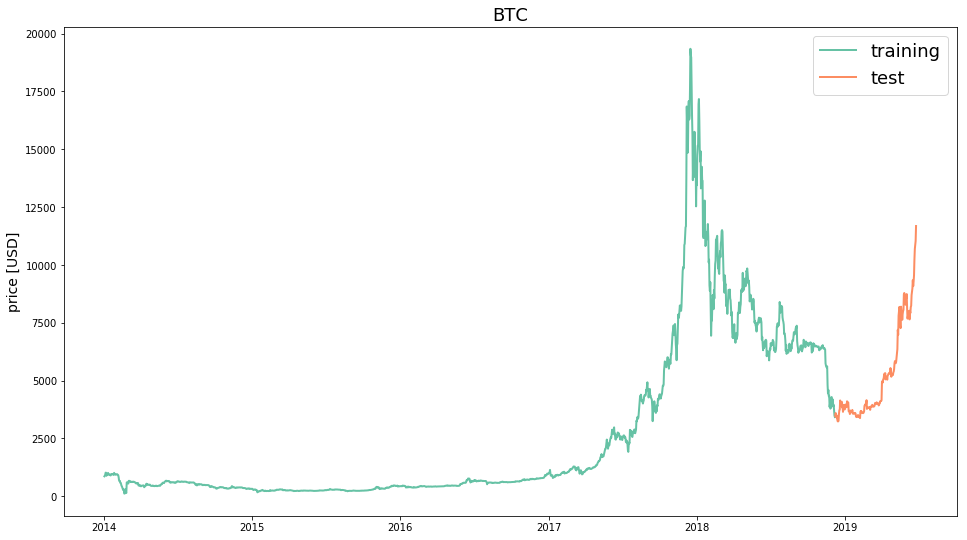

In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(16, 9))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=18)
    ax.legend(loc='best', fontsize=18)

line_plot(train[target_col], test[target_col], 'training', 'test', title='BTC')

In [6]:
def normalise_zero_base(df):
    """ Normalise dataframe column-wise to reflect changes with respect to first entry. """
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    """ Normalise dataframe column-wise min/max. """
    return (df - df.min()) / (data.max() - df.min())

def extract_window_data(df, window_len=10, zero_base=True):
    """ Convert dataframe to overlapping sequences/windows of len `window_data`.
    
        :param window_len: Size of window
        :param zero_base: If True, the data in each window is normalised to reflect changes
            with respect to the first entry in the window (which is then always 0)
    """
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)



def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    """ Prepare data for LSTM. """
    # train test split
    train_data, test_data = train_test_split(df, test_size=test_size)
    
    # extract window data
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    # extract targets
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test


def build_lstm_model(input_data, output_size, neurons=20, activ_func='linear',
                     dropout=0.25, loss='mae', optimizer='adam'):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model




In [7]:
np.random.seed(42)

# data params
window_len = 7
test_size = 0.1
zero_base = True

# model params
lstm_neurons = 20
epochs = 50
batch_size = 4
loss = 'mae'
dropout = 0.25
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/50
1794/1794 [==============================] - 5s 3ms/step - loss: 0.0712
Epoch 2/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0486
Epoch 3/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0425
Epoch 4/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0391
Epoch 5/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0370
Epoch 6/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0363
Epoch 7/50
1794/1794 [==============================] - 4s 2ms/step - loss: 0.0343
Epoch 8/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0336
Epoch 9/50
1794/1794 [==============================] - 3s 2ms/step - loss: 0.0347
Epoch 10/50
1794/1

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()

mean_absolute_error(preds, y_test)

preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)

line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [ ]:
n_points = 30

line_plot(targets[-n_points:], preds[-n_points:], 'actual', 'prediction', lw=3)

In [ ]:
actual_returns = targets.pct_change()[1:]
predicted_returns = preds.pct_change()[1:]

def dual_line_plot(line1, line2, line3, line4, label1=None, label2=None, title='', lw=2):
    import matplotlib.dates as mdates
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(21, 9))
    ax1.plot(line1, label=label1, linewidth=lw)
    ax1.plot(line2, label=label2, linewidth=lw)
    ax2.plot(line3, label=label1, linewidth=lw)
    ax2.plot(line4, label=label2, linewidth=lw)
    ax2.set_xticks(ax1.get_xticks())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.set_ylabel('daily returns', fontsize=14)
    ax2.legend(loc='best', fontsize=18);

In [ ]:
dual_line_plot(actual_returns[-n_points:],
          predicted_returns[-n_points:],
          actual_returns[-n_points:][:-1],
          predicted_returns[-n_points:].shift(-1),
          'actual returns', 'predicted returns', lw=3)

In [ ]:
line_plot(actual_returns[-n_points:][:-1], predicted_returns[-n_points:].shift(-1),
           'actual returns', 'predicted returns', lw=3)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

# actual correlation
corr = np.corrcoef(actual_returns, predicted_returns)[0][1]
ax1.scatter(actual_returns, predicted_returns, color='k', marker='o', alpha=0.5, s=100)
ax1.set_title('r = {:.2f}'.format(corr), fontsize=18)

# shifted correlation
shifted_actual = actual_returns[:-1]
shifted_predicted = predicted_returns.shift(-1).dropna()
corr = np.corrcoef(shifted_actual, shifted_predicted)[0][1]
ax2.scatter(shifted_actual, shifted_predicted, color='k', marker='o', alpha=0.5, s=100)
ax2.set_title('r = {:.2f}'.format(corr), fontsize=18);

In [ ]:
import requests
import pandas as pd
import xlsxwriter

# apiKey = "3d962fc56013560002625148bb9d05b2713e2415f63cf9bf25ccab7612b0de6f" #Karthikeyan
apiKey = "fc90914ed266b5c6c5277e07be3878269cfcc6f4c22be38c4cb8df6b9de3752a" #deweshcrypto

url = "https://min-api.cryptocompare.com/data/histoday"
symbols = ["BTC", "BCH", "DASH", "ETH", "ETC", "LTC", "REP"]

headers = {
    "authorization": "Apikey " + apiKey
}

currency = "USD"

for sym in symbols: 
    payload = {
        "api_key": apiKey,
        "fsym": sym,
        "tsym": currency,
        "limit": 500
    }

    # result = requests.get(url, params=payload).json()
    result = requests.get(url, headers=headers, params=payload).json()
    s_name = sym + '_in_' + currency
    f_name = s_name + '.xlsx'
    
    df = pd.DataFrame(result['Data'])
    df = df[['time', 'close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]
    df = df.set_index('time')
    df.index = pd.to_datetime(df.index, unit='s')
    
    writer = pd.ExcelWriter(f_name, engine='xlsxwriter')
    df.to_excel(writer, sheet_name=s_name)
    writer.save()
    
    print("=========================================")
    print(s_name)
    print("=========================================")
    print(df.head())